In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_images/256).shuffle(60000).batch(2560)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.Reshape((7, 7, 64)))
    model.add(layers.Conv2DTranspose(64, (6, 6), strides=(1, 1), padding='same',use_bias=False))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',use_bias=False))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(1, 1), padding='same',use_bias=False))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same',use_bias=False))
    model.add(layers.ReLU())
    return model

generator = make_generator_model()

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(64, (4, 4), strides=(1, 1), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(64, (6, 6), strides=(1, 1), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model
discriminator = make_discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
  
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

@tf.function
def train_step(images):
    noise = tf.random.normal([2560, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):

    for image_batch in dataset:
      train_step(image_batch)
    if (epoch+1)%10 == 1:
      print ('Epoch: ' + str(epoch + 1))
      generate_and_save_images(generator,
                              epoch + 1,
                              tf.random.normal([25, 100]))
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(5,5))
  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 256, cmap='gray')
      plt.axis('off')
  plt.show()


Epoch: 1


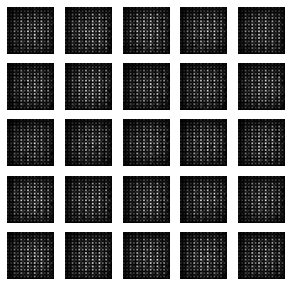

Epoch: 11


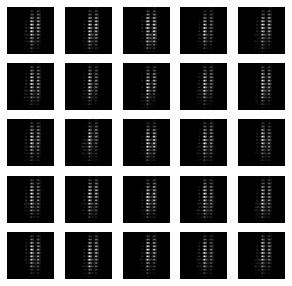

Epoch: 21


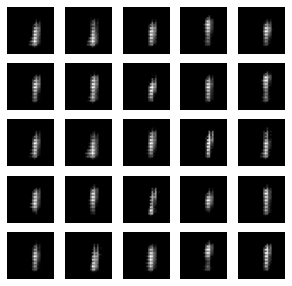

Epoch: 31


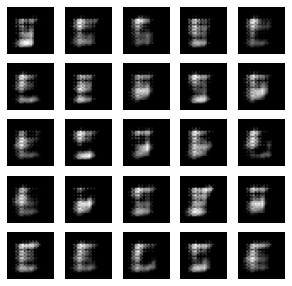

Epoch: 41


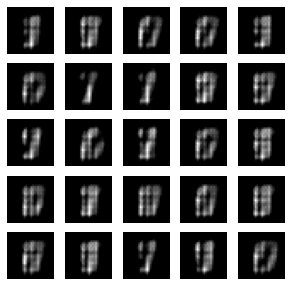

Epoch: 51


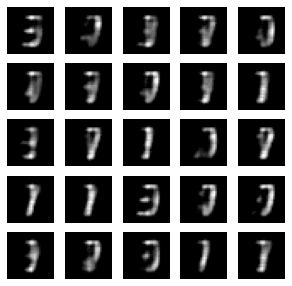

Epoch: 61


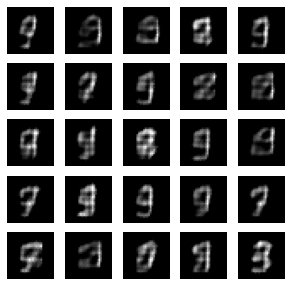

Epoch: 71


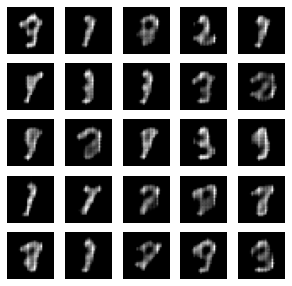

Epoch: 81


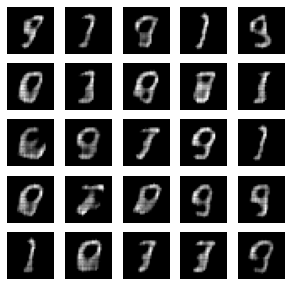

Epoch: 91


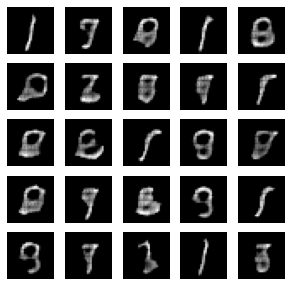

Epoch: 101


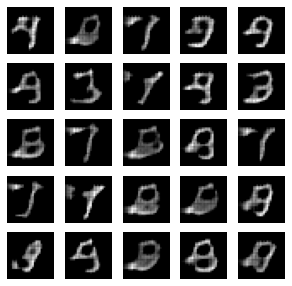

Epoch: 111


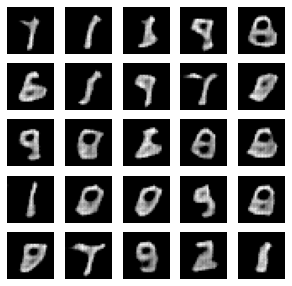

Epoch: 121


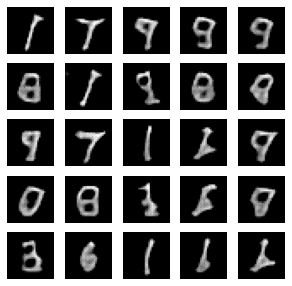

Epoch: 131


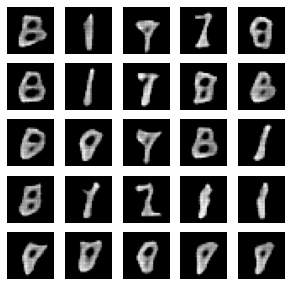

Epoch: 141


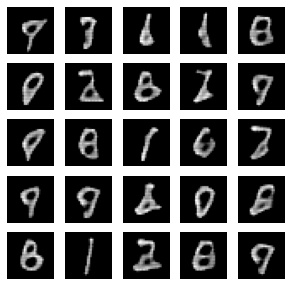

Epoch: 151


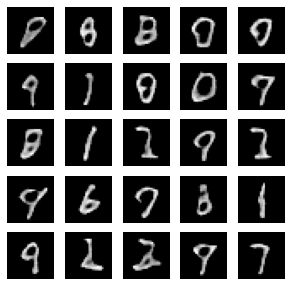

Epoch: 161


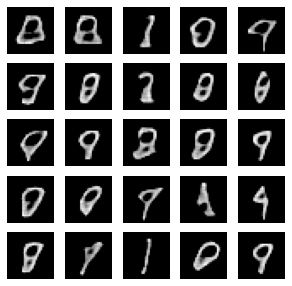

Epoch: 171


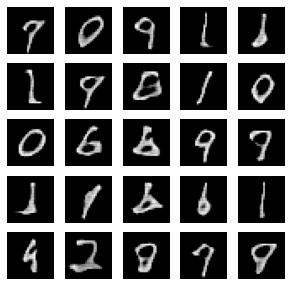

Epoch: 181


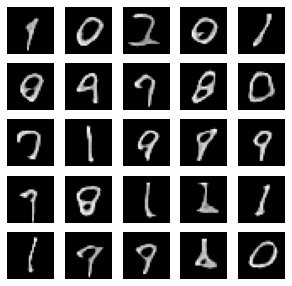

Epoch: 191


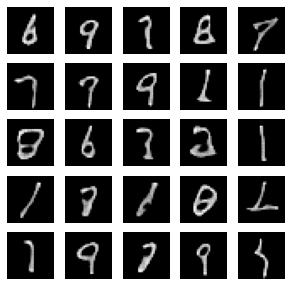

Epoch: 201


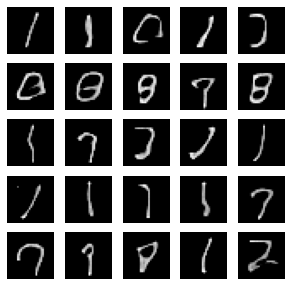

Epoch: 211


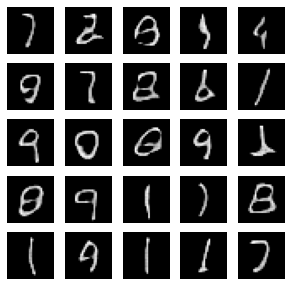

Epoch: 221


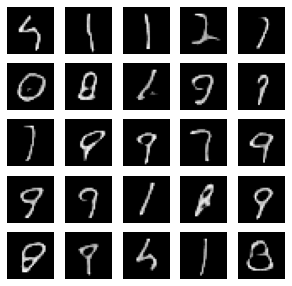

Epoch: 231


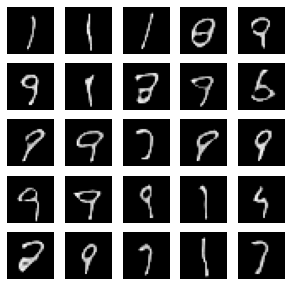

Epoch: 241


In [ ]:
train(train_dataset, 200)